Latest air quality and CO₂ readings for London and globally:
Date: 2025-10-22
PM2.5 (µg/m³): 22
Temperature (°C): 10
Humidity (%): 93
Global CO₂ (ppm) [2025-10-20]: 424.79


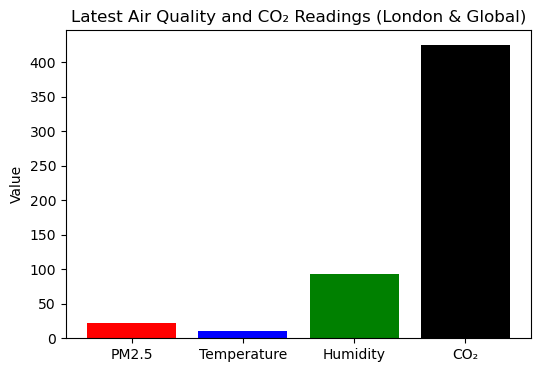


How to read this chart:
- PM2.5: Fine particulate matter, micrograms per cubic meter, for London. Lower is better for health.
- Temperature: Degrees Celsius, for London.
- Humidity: Percent relative humidity, for London.
- CO₂: Global daily value (parts per million) from Mauna Loa Observatory.
All data is live and up to date. You can use this chart for your report or demo hehe.


In [2]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# --- Step 1: Fetch latest PM2.5, temperature, humidity for London from AQICN ---
aqicn_token = "89b21bfd45ccd18a7868916d4acd03b8cd2d97db"
aqicn_url = f"https://api.waqi.info/feed/london/?token={aqicn_token}"

try:
    resp = requests.get(aqicn_url, timeout=10)
    data = resp.json()
    if data.get("status") == "ok":
        iaqi = data["data"]["iaqi"]
        pm25 = iaqi.get("pm25", {}).get("v", None)
        temp = iaqi.get("t", {}).get("v", None)
        hum = iaqi.get("h", {}).get("v", None)
    else:
        pm25 = temp = hum = None
        print("AQICN API did not return valid data for London.")
except Exception as e:
    pm25 = temp = hum = None
    print(f"Error fetching AQICN data: {e}")

# --- Step 2: Fetch latest global CO2 from Mauna Loa (NOAA) ---
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_trend_gl.txt"
try:
    resp = requests.get(url, timeout=10)
    lines = resp.text.splitlines()
    data_lines = [line for line in lines if not line.startswith("#") and line.strip()]
    last_line = data_lines[-1]
    year, month, day, co2, *_ = last_line.split()
    co2_date = f"{year}-{month.zfill(2)}-{day.zfill(2)}"
    co2 = float(co2)
except Exception as e:
    co2 = None
    co2_date = None
    print(f"Error fetching CO₂ data: {e}")

# --- Step 3: Display and plot ---
print("Latest air quality and CO₂ readings for London and globally:")
print(f"Date: {datetime.now().strftime('%Y-%m-%d')}")
print(f"PM2.5 (µg/m³): {pm25 if pm25 is not None else 'No data'}")
print(f"Temperature (°C): {temp if temp is not None else 'No data'}")
print(f"Humidity (%): {hum if hum is not None else 'No data'}")
print(f"Global CO₂ (ppm) [{co2_date if co2_date else 'No data'}]: {co2 if co2 is not None else 'No data'}")

# Only plot if at least one value is present
values = [pm25, temp, hum, co2]
labels = ["PM2.5", "Temperature", "Humidity", "CO₂"]
colors = ["red", "blue", "green", "black"]
if any(v is not None for v in values):
    plt.figure(figsize=(6,4))
    plt.bar(labels, [v if v is not None else 0 for v in values], color=colors)
    plt.ylabel("Value")
    plt.title("Latest Air Quality and CO₂ Readings (London & Global)")
    plt.show()
else:
    print("No valid data to plot.")

print("\nHow to read this chart:")
print("- PM2.5: Fine particulate matter, micrograms per cubic meter, for London. Lower is better for health.")
print("- Temperature: Degrees Celsius, for London.")
print("- Humidity: Percent relative humidity, for London.")
print("- CO₂: Global daily value (parts per million) from Mauna Loa Observatory.")
print("All data is live and up to date. You can use this chart for your report or demo hehe.")


In [11]:
import requests
import pandas as pd

API_KEY = "YOUR_OPENAQ_API_KEY"
headers = {"X-API-Key": API_KEY}

# Example: coordinates for New York City
latitude = 40.7128
longitude = -74.0060
radius = 20000  # 20 km
parameter = "pm25"

url = "https://api.openaq.org/v3/measurements"
params = {
    "coordinates": f"{latitude},{longitude}",
    "radius": radius,
    "parameter": parameter,
    "limit": 100,
    "sort": "desc"
}

r = requests.get(url, headers=headers, params=params)
data = r.json().get("results", [])

df_pm25 = pd.DataFrame([{
    "datetime": d["date"]["utc"],
    "value": d["value"],
    "unit": d["unit"],
    "location": d["location"]
} for d in data])

print(df_pm25.head())


Empty DataFrame
Columns: []
Index: []


In [12]:
"""
aqm_live_demo.py

Fetch Open-Meteo and OpenAQ data for a city, merge hourly, train a one hour ahead XGBoost model,
compute a SHAP explanation for one prediction, save results.

Usage:
    python aqm_live_demo.py
"""

import os
import time
import requests
import pandas as pd
import numpy as np
import pytz
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap
import joblib

# ----------------------------
# Configuration
# ----------------------------
CITY_NAME = "London"
CITY_LAT = 51.5074
CITY_LON = -0.1278
TIMEZONE = "Europe/London"

NDAYS = 14  # how many days of history to fetch for training and demo
OPENMETEO_BASE = "https://api.open-meteo.com/v1/forecast"
OPENAQ_BASE = "https://api.openaq.org/v2/measurements"

OUT_DIR = "aqm_output"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# Helpers
# ----------------------------
def fetch_openmeteo(lat, lon, start_date, end_date, timezone=TIMEZONE):
    """
    Fetch hourly meteorological data from Open-Meteo.
    Returns a pandas DataFrame with local timezone index.
    """
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,pressure_msl",
        "start_date": start_date,
        "end_date": end_date,
        "timezone": timezone
    }
    r = requests.get(OPENMETEO_BASE, params=params, timeout=30)
    r.raise_for_status()
    j = r.json()
    df = pd.DataFrame({
        "time": j["hourly"]["time"],
        "temperature_C": j["hourly"]["temperature_2m"],
        "relative_humidity": j["hourly"]["relativehumidity_2m"],
        "wind_speed": j["hourly"].get("windspeed_10m"),
        "wind_dir": j["hourly"].get("winddirection_10m"),
        "pressure_msl": j["hourly"].get("pressure_msl"),
    })
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time").sort_index()
    return df

def fetch_openaq_pm25(lat, lon, start_iso, end_iso, radius_m=10000, parameter="pm25"):
    """
    Fetch OpenAQ measurements using the v2 API in a radius around lat lon.
    Returns a list of measurement dicts.
    """
    results = []
    page = 1
    while True:
        params = {
            "parameter": parameter,
            "coordinates": f"{lat},{lon}",
            "radius": radius_m,
            "date_from": start_iso,
            "date_to": end_iso,
            "limit": 100,
            "page": page,
            "sort": "desc",
            "order_by": "datetime"
        }
        r = requests.get(OPENAQ_BASE, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        res = data.get("results", [])
        if len(res) == 0:
            break
        results.extend(res)
        page += 1
        time.sleep(0.15)
        # safe break to avoid infinite loop
        if page > 400:
            break
    return results

def openaq_to_hourly_df(results, local_tz=TIMEZONE):
    """
    Convert OpenAQ results list into hourly averaged pm25 series in local timezone.
    """
    rows = []
    for r in results:
        dt_utc = r.get("date", {}).get("utc")
        if not dt_utc:
            continue
        rows.append({
            "utc": pd.to_datetime(dt_utc),
            "value": r.get("value"),
            "unit": r.get("unit"),
            "location": r.get("location"),
            "latitude": r.get("coordinates", {}).get("latitude"),
            "longitude": r.get("coordinates", {}).get("longitude"),
        })
    if not rows:
        return pd.DataFrame(columns=["pm25_ugm3"])
    df = pd.DataFrame(rows)
    df["time_local"] = df["utc"].dt.tz_localize("UTC").dt.tz_convert(local_tz)
    df["time_hour"] = df["time_local"].dt.floor("H")
    hourly = df.groupby("time_hour")["value"].mean().reset_index().rename(columns={"value": "pm25_ugm3"})
    hourly["time_hour"] = pd.to_datetime(hourly["time_hour"])
    hourly = hourly.set_index("time_hour").sort_index()
    return hourly

# ----------------------------
# Step 1 Fetch data
# ----------------------------
tz = pytz.timezone(TIMEZONE)
now = datetime.now(tz).replace(minute=0, second=0, microsecond=0)
start_dt = now - timedelta(days=NDAYS)
start_date_str = start_dt.strftime("%Y-%m-%d")
end_date_str = now.strftime("%Y-%m-%d")

print("Fetching Open-Meteo hourly data for", CITY_NAME, start_date_str, "to", end_date_str)
om_df = fetch_openmeteo(CITY_LAT, CITY_LON, start_date_str, end_date_str)

# OpenAQ uses ISO timestamps in UTC
start_iso = start_dt.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%SZ")
end_iso = now.astimezone(pytz.UTC).strftime("%Y-%m-%dT%H:%M:%SZ")
print("Fetching OpenAQ pm25 data for", CITY_NAME, "from", start_iso, "to", end_iso)
oa_results = fetch_openaq_pm25(CITY_LAT, CITY_LON, start_iso, end_iso, radius_m=15000, parameter="pm25")
oa_hourly = openaq_to_hourly_df(oa_results, local_tz=TIMEZONE)

# ----------------------------
# Step 2 Merge and align hourly
# ----------------------------
# create hourly index from meteorology
hour_index = pd.date_range(start=om_df.index.min(), end=om_df.index.max(), freq="H", tz=om_df.index.tz)
df = om_df.reindex(hour_index).copy()
# join pm25
if not oa_hourly.empty:
    # ensure timezone aware index
    if oa_hourly.index.tz is None:
        oa_hourly.index = oa_hourly.index.tz_localize(TIMEZONE)
    oa_hourly = oa_hourly.tz_convert(TIMEZONE)
    df = df.join(oa_hourly["pm25_ugm3"], how="left")
else:
    df["pm25_ugm3"] = np.nan

# show how many rows and missing pm25
print("Merged rows", len(df), "pm25 missing count", df["pm25_ugm3"].isna().sum())

# ----------------------------
# Step 3 Simple cleaning
# ----------------------------
# Interpolate short gaps for meteorology up to 6 hours
df["temperature_C"] = df["temperature_C"].interpolate(limit=6, limit_direction="both")
df["relative_humidity"] = df["relative_humidity"].interpolate(limit=6, limit_direction="both")
df["wind_speed"] = df["wind_speed"].interpolate(limit=6, limit_direction="both")
df["pressure_msl"] = df["pressure_msl"].interpolate(limit=6, limit_direction="both")

# For pm25 do a cautious approach
# forward fill up to 3 hours, then linear interpolate up to 6 hours
df["pm25_ugm3"] = df["pm25_ugm3"].fillna(method="ffill", limit=3)
df["pm25_ugm3"] = df["pm25_ugm3"].interpolate(limit=6, limit_direction="both")

# drop rows that still have no pm25 after reasonable fills
df = df.reset_index().rename(columns={"index": "time"})
df = df.dropna(subset=["pm25_ugm3"]).set_index("time").sort_index()
print("After fill rows", len(df), "pm25 missing", df["pm25_ugm3"].isna().sum())

# Save merged data
merged_path = os.path.join(OUT_DIR, f"{CITY_NAME.lower()}_merged_{NDAYS}d.parquet")
df.to_parquet(merged_path)
print("Saved merged parquet to", merged_path)

# ----------------------------
# Step 4 Feature engineering
# ----------------------------
# create lag features and rolling means
lags = [1, 2, 3, 6, 12, 24]
for lag in lags:
    df[f"pm25_lag_{lag}h"] = df["pm25_ugm3"].shift(lag)

# rolling means
df["pm25_roll_3h"] = df["pm25_ugm3"].rolling(window=3, min_periods=1).mean().shift(1)
df["pm25_roll_24h"] = df["pm25_ugm3"].rolling(window=24, min_periods=1).mean().shift(1)

# meteorology lags
df["temp_lag_1h"] = df["temperature_C"].shift(1)
df["rh_lag_1h"] = df["relative_humidity"].shift(1)

# time features
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month

# drop rows with na created by shifting
df = df.dropna().copy()
print("After feature engineering rows", len(df))

# ----------------------------
# Step 5 Setup supervised target one hour ahead
# ----------------------------
df["pm25_target_1h"] = df["pm25_ugm3"].shift(-1)  # predict next hour
df = df.dropna(subset=["pm25_target_1h"]).copy()

# feature list
feature_cols = [
    "pm25_ugm3",
    "pm25_lag_1h",
    "pm25_lag_2h",
    "pm25_roll_3h",
    "pm25_roll_24h",
    "temp_lag_1h",
    "rh_lag_1h",
    "wind_speed",
    "pressure_msl",
    "hour",
    "dayofweek",
]
# ensure features exist
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols]
y = df["pm25_target_1h"]

# ----------------------------
# Step 6 Train test split respecting time order
# ----------------------------
# use the last 20 percent for test
n = len(df)
train_end = int(n * 0.8)
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_test = X.iloc[train_end:]
y_test = y.iloc[train_end:]

print("Train rows", len(X_train), "Test rows", len(X_test))

# ----------------------------
# Step 7 Train XGBoost baseline
# ----------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.1,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}
evallist = [(dtrain, "train"), (dtest, "eval")]
num_round = 200
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=20, verbose_eval=False)

# save model
model_path = os.path.join(OUT_DIR, "xgb_pm25_1h.model")
bst.save_model(model_path)
print("Saved xgboost model to", model_path)

# ----------------------------
# Step 8 Evaluate
# ----------------------------
y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Test MAE {mae:.3f} RMSE {rmse:.3f} R2 {r2:.3f}")

# quick plot of last part of test
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="obs")
plt.plot(y_test.index, y_pred, label="pred")
plt.legend()
plt.title("One hour ahead PM2.5 obs vs pred")
plt.tight_layout()
plt.show()

# ----------------------------
# Step 9 SHAP explanation for a sample
# ----------------------------
# use TreeExplainer for XGBoost which is fast and exact for tree models
explainer = shap.TreeExplainer(bst)
# pick last test row for local explanation
sample_X = X_test.iloc[[-1]]
shap_vals = explainer.shap_values(sample_X)
print("SHAP values shape", np.array(shap_vals).shape)

# summary plot for global importance on train set
shap_values_train = explainer.shap_values(X_train)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_train, X_train, show=True, plot_size=(8,6))
plt.tight_layout()

# force plot for the single sample saved to html
force_html = shap.force_plot(explainer.expected_value, shap_vals, sample_X, matplotlib=False, show=False)
html_path = os.path.join(OUT_DIR, "shap_force_sample.html")
shap.save_html(html_path, force_html)
print("Saved shap force plot to", html_path)

# ----------------------------
# Step 10 Save artifacts and feature importance
# ----------------------------
# feature importance from xgboost
importance = bst.get_score(importance_type="weight")
imp_df = pd.DataFrame(list(importance.items()), columns=["feature", "weight"]).sort_values("weight", ascending=False)
imp_df.to_csv(os.path.join(OUT_DIR, "xgb_feature_importance.csv"), index=False)
print("Saved feature importance to csv")

# save model in joblib too using sklearn wrapper convenience
sk_model = xgb.XGBRegressor()
sk_model._Booster = bst
sk_model.set_params(**{"n_estimators": bst.best_iteration + 1})
joblib.dump(sk_model, os.path.join(OUT_DIR, "xgb_sklearn_wrapper.joblib"))

# Save processed training data sample
df_sample_path = os.path.join(OUT_DIR, "processed_training_sample.parquet")
df.reset_index().to_parquet(df_sample_path)
print("Saved processed data to", df_sample_path)

print("All done. Output folder", OUT_DIR)


ModuleNotFoundError: No module named 'xgboost'